# [Dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

# **Genre Prediction**


# Frame The Problem And Look At The Big Picture

1. ***Define the objective in business terms***:

- The goal of this project is to build a system that can classify music genres based on audio features extracted from songs. For this, we’re using the GTZAN dataset, which contains tracks labeled across 10 genres, such as Blues, Jazz, Rock, and Classical. The project involves analyzing the dataset to uncover patterns in the audio features that can help distinguish one genre from another. This work has practical applications in many areas. For example, music streaming platforms could use a system like this to improve their recommendation algorithms by better understanding the genres of songs. It could also help organize large music libraries by automatically tagging tracks with the correct genre, saving time and reducing human errors. Beyond that, it could provide insights into genre trends, which could be useful for the music industry in understanding listener preferences and market dynamics. Our ultimate goal is to develop a system that is both accurate and insightful, demonstrating the potential of audio-based classification for real-world use cases. Along the way, we’ll focus on understanding how audio features correlate with genre characteristics and how to improve the system’s accuracy through experimentation and optimization.

2. ***How will your solution be used***:
- Music streaming platforms could integrate it into their recommendation systems
- Music libraries could use it for automated genre tagging
- Music industry analysts could use it to study genre trends and market dynamics
- Could be used in real-time (for live genre classification) or batch processing (for library organization)

3. ***Current solutions/workarounds***:
- Manual genre tagging by music experts
- Existing audio classification like https://www.submithub.com/whats-my-genre

4. ***Problem framing***:
- This is a supervised learning problem as we have labeled data (songs with known genres)
- It's a multi-class classification task (10 different genres)
- Can be implemented as either online (real-time) or offline (batch) depending on the use case
- The GTZAN dataset provides labeled training data

5. ***Performance measurement***:
- Classification metrics like accuracy, precision, recall, and F1-score
- Confusion matrix to understand misclassifications between genres
- The document shows they're using recall_macro as the scoring metric for GridSearchCV
- Cross-validation scores to ensure robust performance

6. ***Minimum performance needed***:
- Not sure

7. ***Comparable problems***:
- Speech recognition
- Sound classification
- Audio fingerprinting
- Music mood classification
- Artist identification from audio  
These all use similar audio feature extraction and classification techniques

8. ***Human expertise availability***:
- Music experts can manually classify genres
- Domain knowledge about audio features and their relationship to genres is available (as shown in the feature descriptions)

9. ***Manual solution process***:  
A human would:
- Listen to the audio
- Identify key characteristics like:
  - Instruments used
  - Rhythm patterns
  - Tempo
  - Vocal style
  - Harmonic structure
- Compare these characteristics against known genre conventions
- Make a classification based on overall similarity to genre patterns

10. ***Assumptions made***:
- The 10 genres in GTZAN dataset are sufficient to represent music diversity
- 3-second segments are enough to determine genre
- The dataset is representative of real-world music
- The genre labels in the training data are accurate

These assumptions could be verified by:
- Validating genre labels with multiple music experts
- Testing the model on more recent music releases

# **Get The Data**

#### Imports:

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading the data:

In [3]:
# Function to load the dataset
def load_dataset(dataset_name=None):
    return pd.read_csv(f'data/{dataset_name}')

In [4]:
data = load_dataset('features_3_sec.csv')

In [5]:
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues



#### *Data Overview*

- The dataset contains 2 sets of audio features including spectral measurements, MFCCs, and temporal characteristics with no missing values.
- One dataset containing 30 second samples and the corresponding values and the other 3 second samples, both have the same features
- The dataset contains 1000 30 second songs with 100 songs for each of the 10 genres in a `.wav` format.
- The dataset also contains a Mel Spectrogram corresponding to each of the songs.

| Feature | Description |
|---------|------------|
| chroma_stft | Represents pitch content by mapping spectral data into 12 pitch classes |
| rms | Root Mean Square energy - represents the loudness/volume of the audio |
| spectral_centroid | Indicates where the "center of mass" of the sound is - relates to sound brightness |
| spectral_bandwidth | Width of the spectrum - indicates the range of frequencies |
| rolloff | Frequency below which most of the signal's energy is contained |
| zero_crossing_rate | Rate at which the signal changes from positive to negative - relates to noisiness |
| harmony | Measure of harmonic content vs noise in the signal |
| perceptr | Perceptual features of the sound |
| tempo | Speed/pace of the music in beats per minute |
| mfcc1-20 | Mel-frequency cepstral coefficients - represent the overall shape of the spectral envelope |

Note: Each feature has both _mean and _var (variance) measurements, representing the average value and how much it varies throughout the audio sample.


- 1,000 entries with 60 columns
- All data fields are completely populated
- Data types:
  - float64: 57 columns (audio features)
  - int64: 1 column (length)
  - object: 2 columns (filename, label)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [7]:
data.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,9990.0,9990.000000,9990.000000,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,66149.0,0.379534,0.084876,0.130859,2.676388e-03,2199.219431,4.166727e+05,2241.385959,1.182711e+05,4566.076592,...,1.448240,49.988755,-4.198706,51.962753,0.739943,52.488851,-2.497306,54.973829,-0.917584,57.322614
std,0.0,0.090466,0.009637,0.068545,3.585628e-03,751.860611,4.349644e+05,543.854449,1.013505e+05,1642.065335,...,5.735149,34.442816,5.677379,36.400669,5.181313,38.177120,5.111799,41.585677,5.253243,46.444212
min,66149.0,0.107108,0.015345,0.000953,4.379535e-08,472.741636,8.118813e+02,499.162910,1.183520e+03,658.336276,...,-26.850016,1.325786,-27.809795,1.624544,-20.733809,3.437439,-27.448456,3.065302,-35.640659,0.282131
25%,66149.0,0.315698,0.079833,0.083782,6.145900e-04,1630.680158,1.231961e+05,1887.455790,4.876553e+04,3378.311110,...,-2.227478,29.584894,-7.951722,29.863448,-2.516638,29.636197,-5.734123,30.496412,-4.004475,30.011365
50%,66149.0,0.384741,0.085108,0.121253,1.491318e-03,2208.628236,2.650692e+05,2230.575595,8.996072e+04,4631.377892,...,1.461623,41.702393,-4.443021,42.393583,0.733772,41.831377,-2.702366,43.435253,-1.030939,44.332155
75%,66149.0,0.442443,0.091092,0.176328,3.130862e-03,2712.581884,5.624152e+05,2588.340505,1.585674e+05,5591.634521,...,5.149752,59.274619,-0.726945,61.676964,3.888734,62.033906,0.514246,65.328602,2.216603,68.210421
max,66149.0,0.749481,0.120964,0.442567,3.261522e-02,5432.534406,4.794119e+06,3708.147554,1.235143e+06,9487.446477,...,39.144405,683.932556,34.048843,529.363342,36.970322,629.729797,31.365425,1143.230591,34.212101,910.473206


### *Data Histograms*

- Looking at these histograms, most of the audio features (like pitch, volume, and frequency measurements) follow bell-shaped distributions centered around specific values, while the variance features (showing how much these measurements change) tend to have right-skewed distributions with long tails, meaning most songs have small variations but some have very large changes in their audio characteristics.

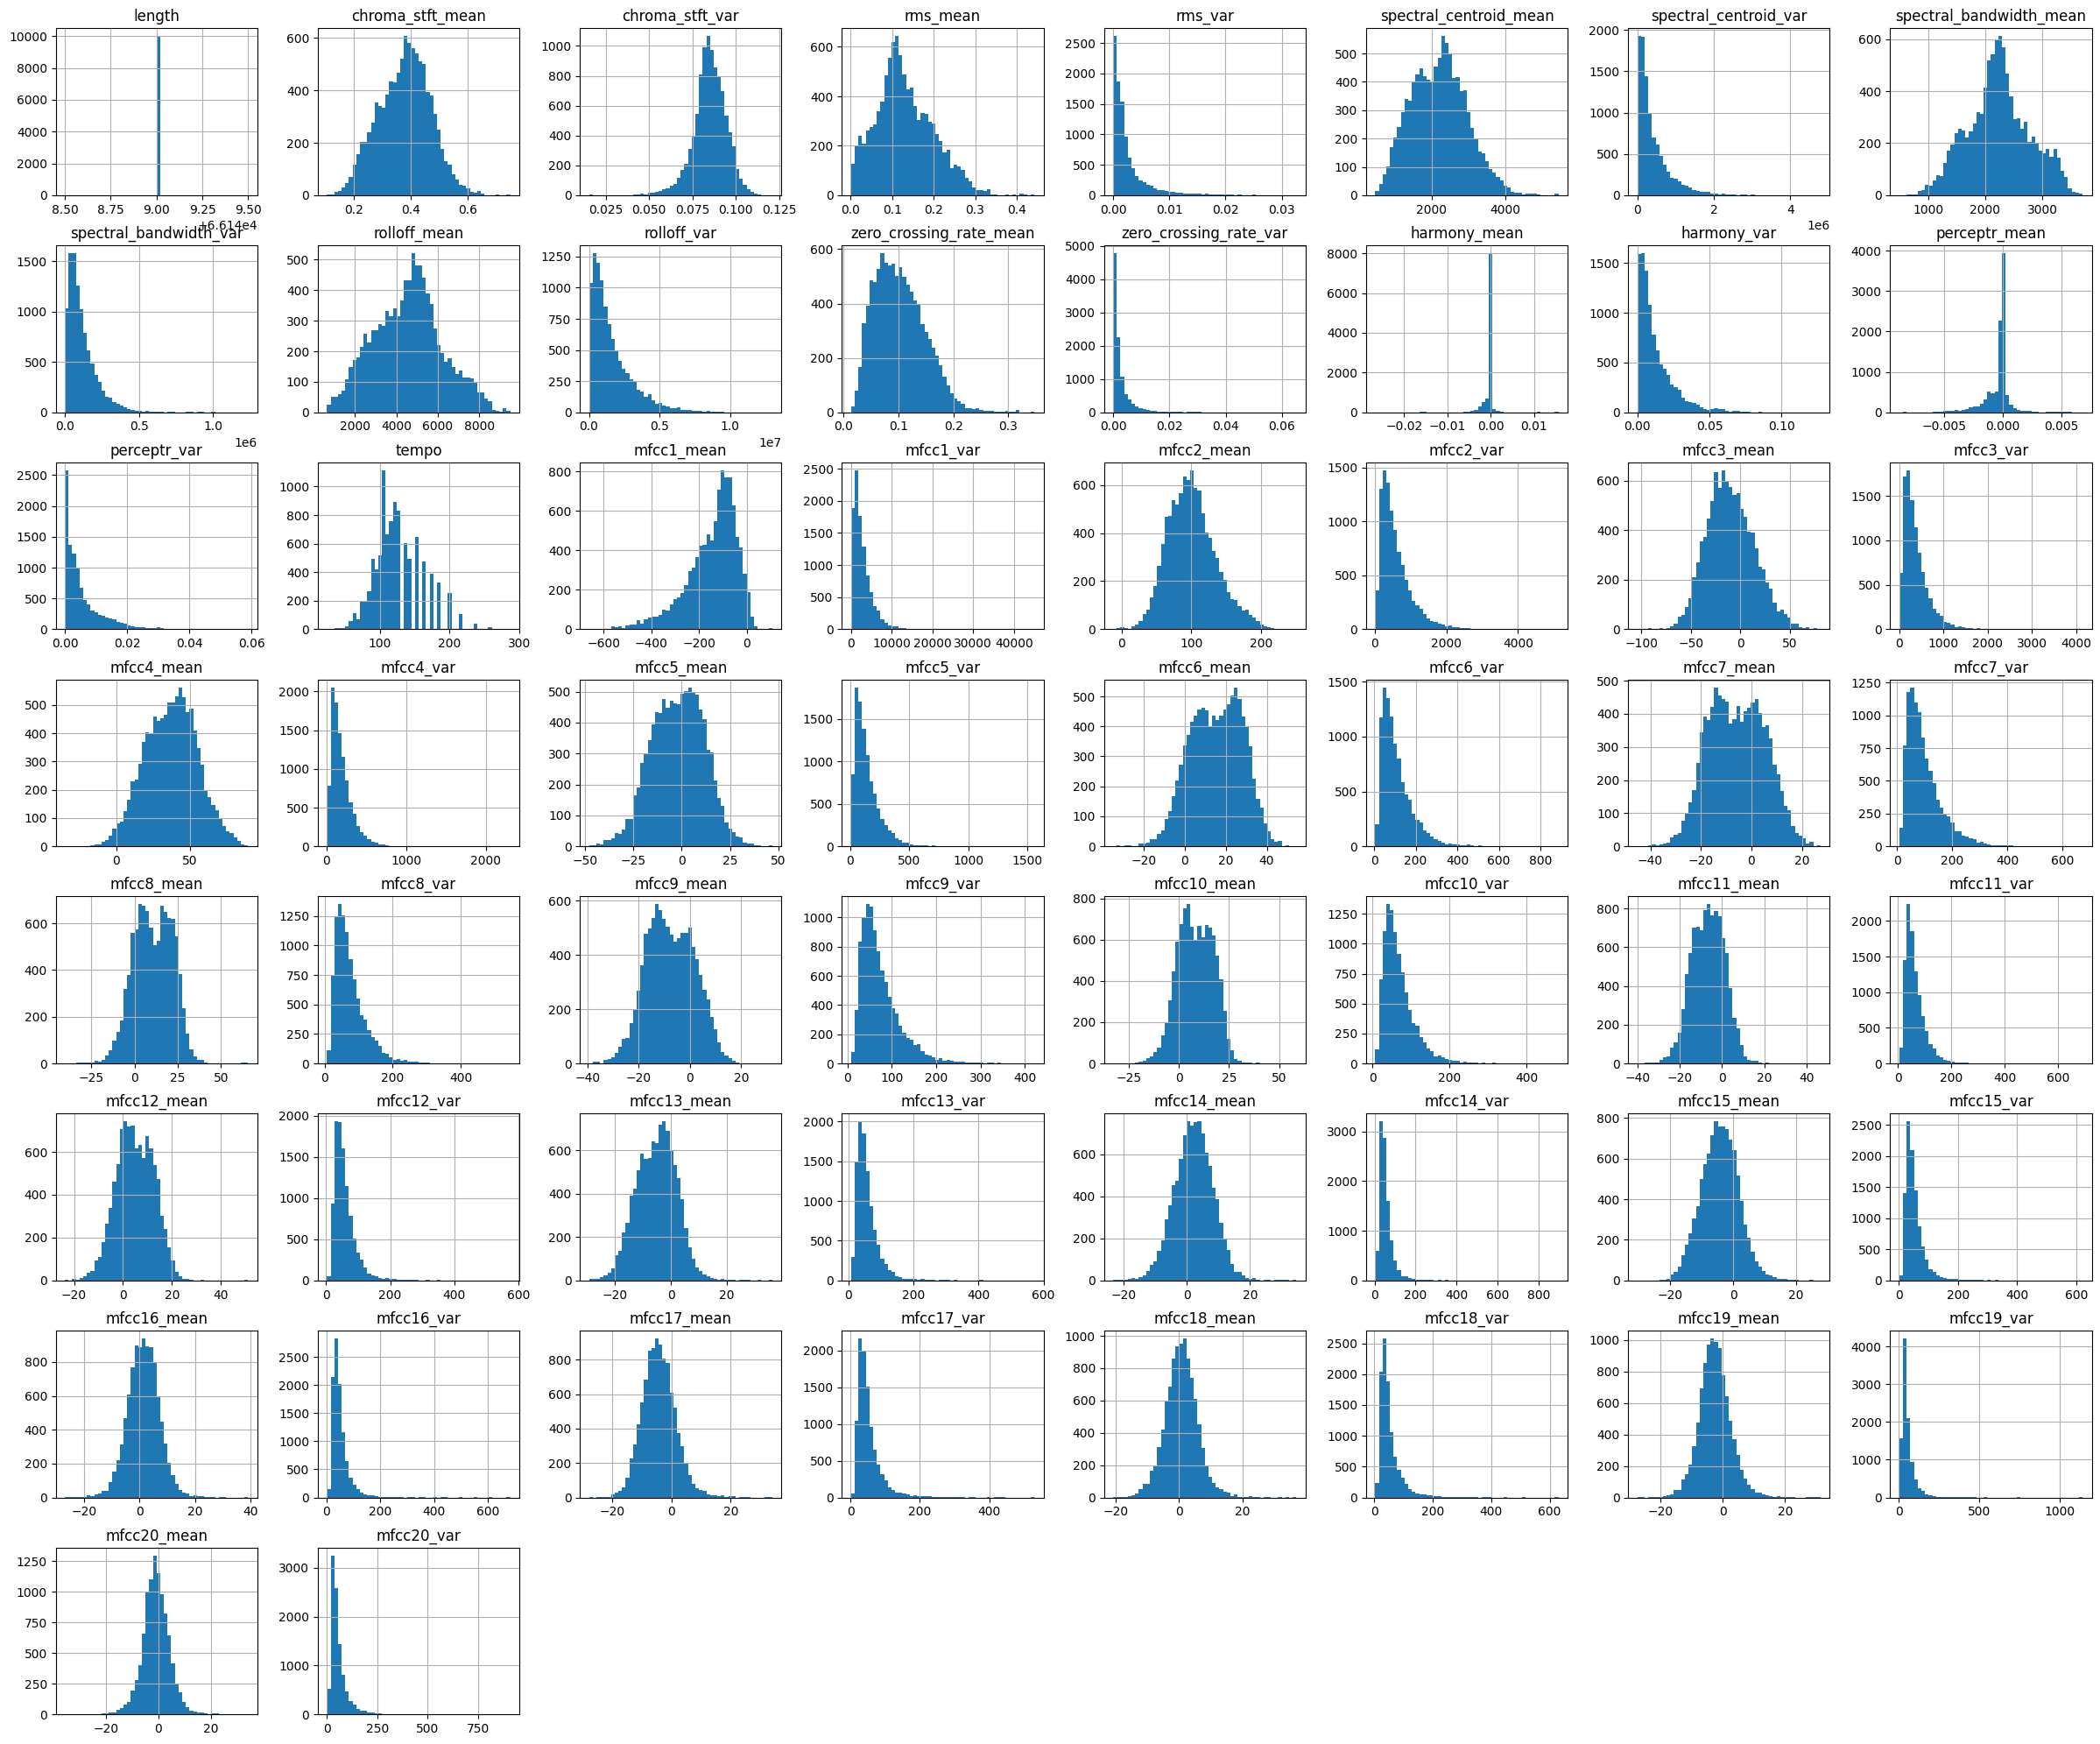

In [8]:
data.hist(bins=50, figsize=(30,25));

### *Splitting The Data Into Two Subsets*

-  The `train_set` containing 80% of the data for training and `test_set` containing 20% for testing, with the split being reproducible due to the specified `random_state`.

In [9]:
# Split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
data = train

# **Discover & Visualize the Data to Gain Insights**

### *Correlation Matrix Of Numerical Features* 
- This correlation matrix might look a bit tricky, but you can spot some patterns between audio features and MFCCs. In the upper left section, you’ll notice some moderate relationships between spectral and temporal audio features.

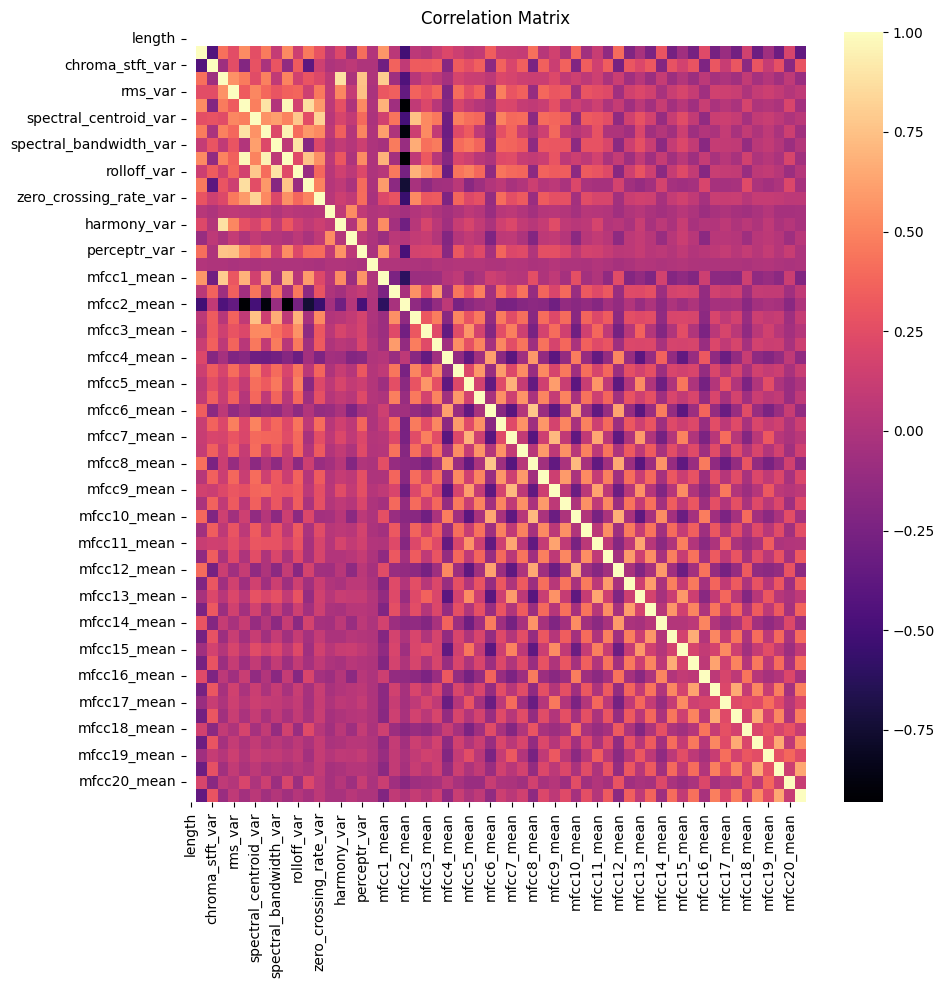

In [10]:
numeric_columns = data.select_dtypes(include=[np.number])

# Corelation matrix with sns
corr = numeric_columns.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False, cmap='magma')
plt.title('Correlation Matrix')
plt.show()

### **RMS Feature Distributions Across Music Genres**

- The plot shows the distribution of the Root Mean Square (RMS) feature for different music genres, visualized using Kernel Density Estimation (KDE). It highlights how each genre's energy profile (loudness) varies, with genres like hip-hop and rock having distinct RMS characteristics compared to classical or jazz, which show more concentrated and narrower distributions.

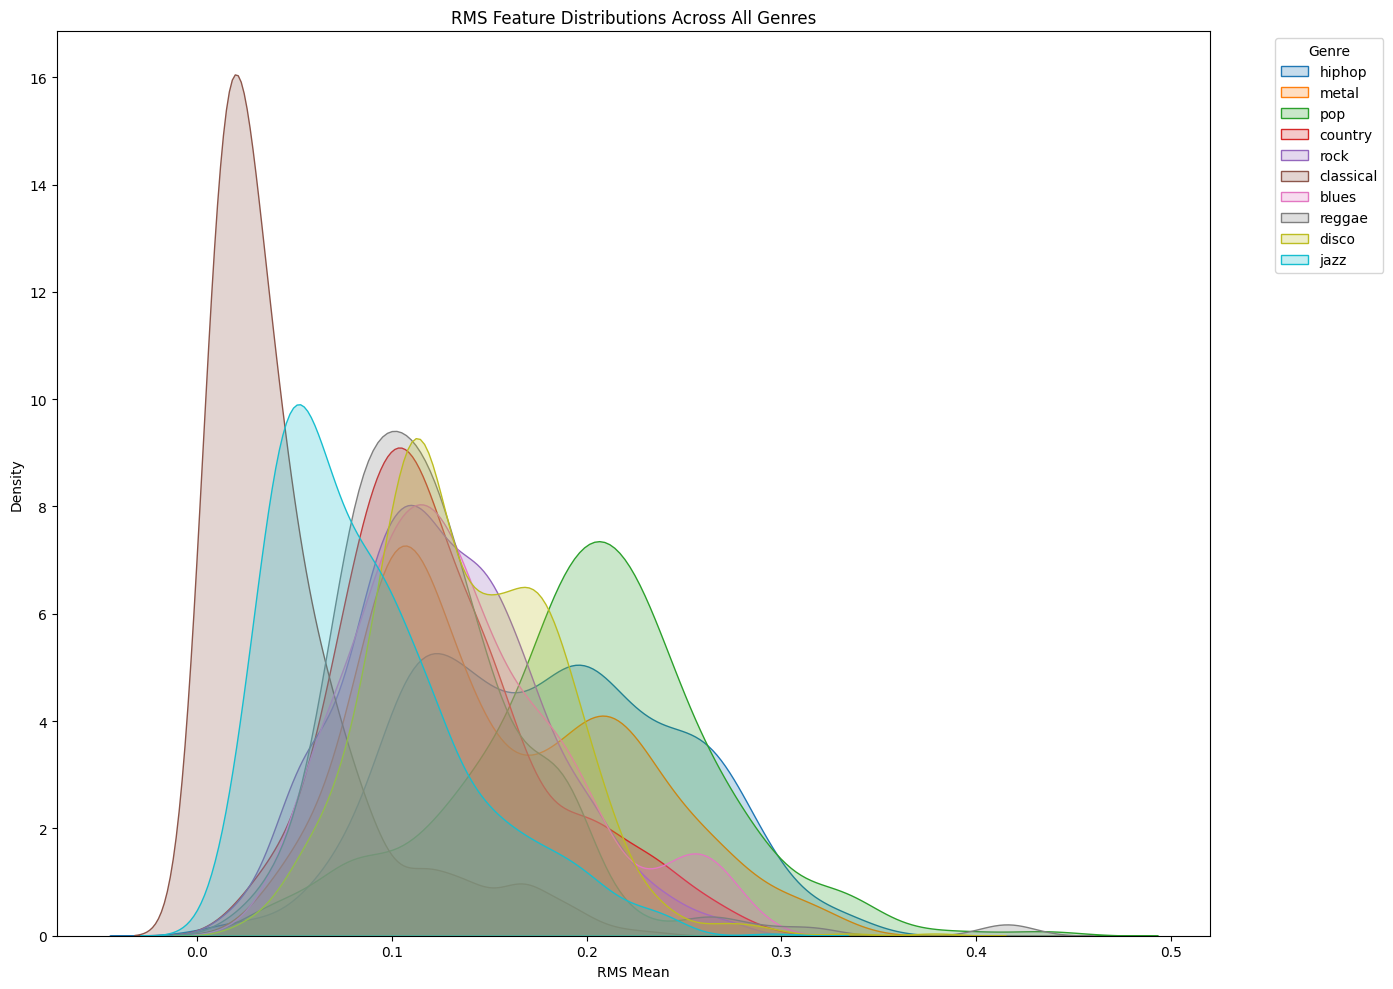

In [11]:
import warnings
plt.figure(figsize=(14, 10))

# Loop through all unique genres and plot their RMS feature distribution
warnings.filterwarnings('ignore')
for genre in data['label'].unique():
    sns.kdeplot(data=data[data['label'] == genre]['rms_mean'], label=genre, shade=True)

plt.title('RMS Feature Distributions Across All Genres')
plt.xlabel('RMS Mean')
plt.ylabel('Density')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

### *Spectral Centroid Across Genres*
- This chart compares the brightness or treble characteristics of different music genres using box plots, where higher values indicate brighter, more treble-heavy sounds, and lower values indicate darker, more bass-heavy sounds. Pop music shows the highest median brightness while classical and blues genres tend toward darker tones, and jazz displays the most variability in its tonal characteristics, ranging from very dark to very bright sounds.

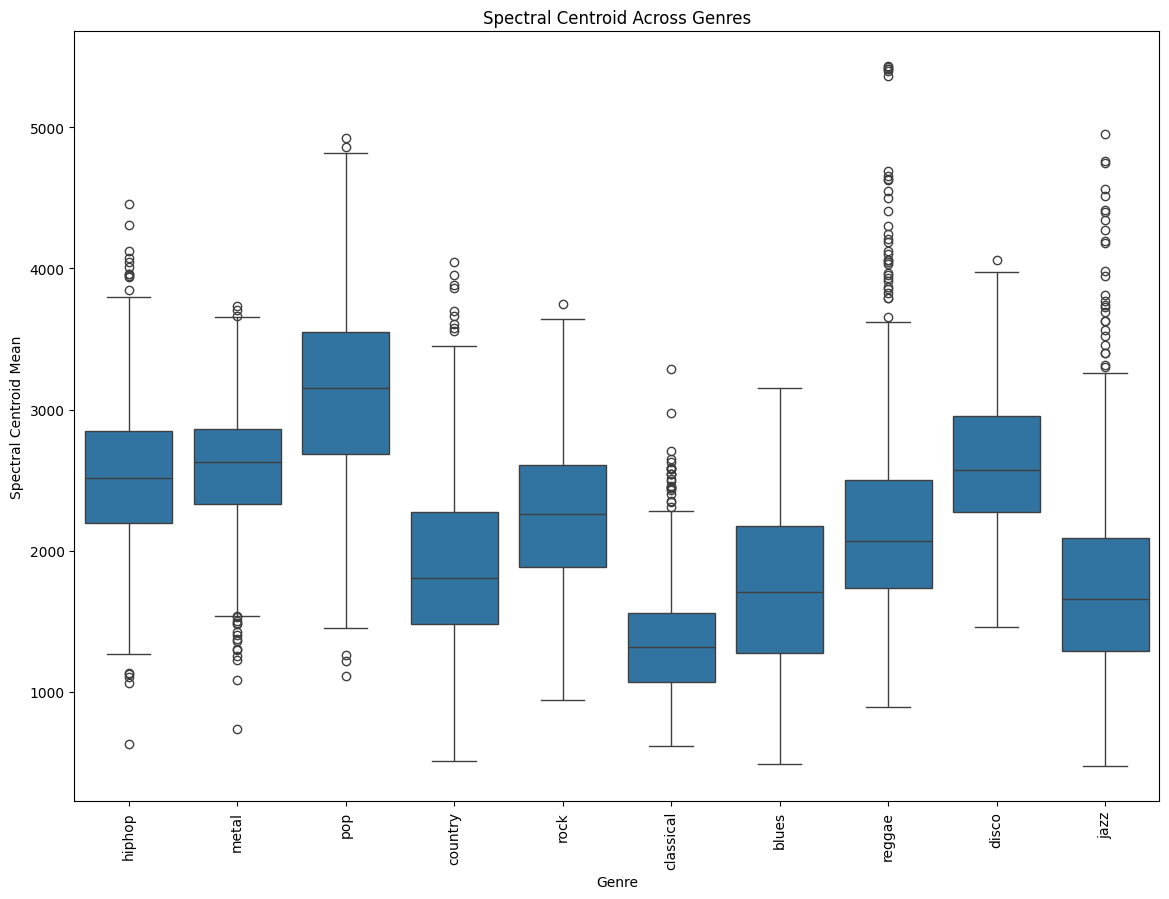

In [12]:
# Visualizing spectral_centroid across genres
plt.figure(figsize=(14, 10))
sns.boxplot(x='label', y='spectral_centroid_mean', data=data)
plt.title('Spectral Centroid Across Genres')
plt.xlabel('Genre')
plt.ylabel('Spectral Centroid Mean')
plt.xticks(rotation=90)
plt.show()



### *MFCC1 Mean Across Genres*

- This chart compares the first Mel-frequency cepstral coefficient (MFCC1) across different music genres, which reflects the overall energy distribution in the frequency spectrum. Classical music has the lowest median MFCC1 values and the most variability, indicating it has less consistent energy. Metal and pop, on the other hand, have higher median values, showing they have more consistent and energetic frequency content.

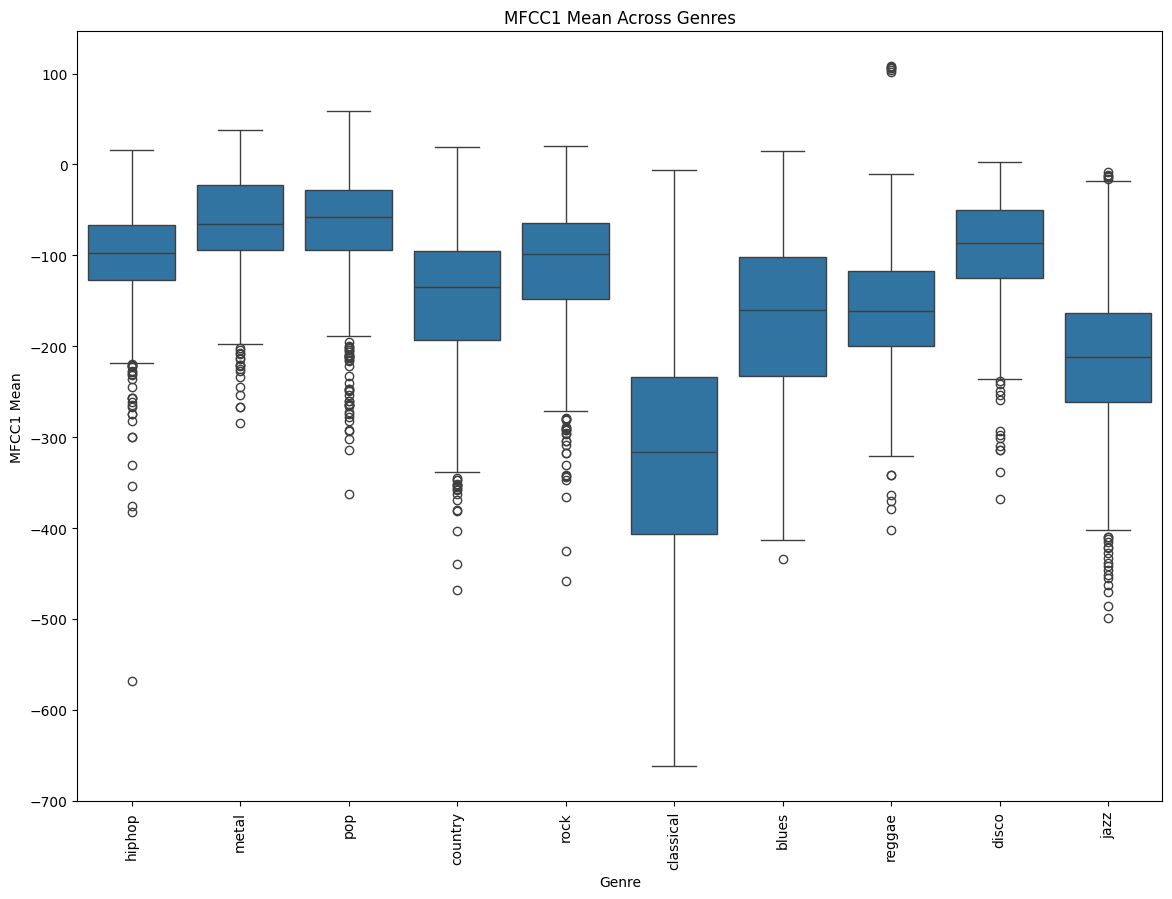

In [13]:
# Visualizing mfcc1_mean across genres
plt.figure(figsize=(14, 10))
sns.boxplot(x='label', y='mfcc1_mean', data=data)
plt.title('MFCC1 Mean Across Genres')
plt.xlabel('Genre')
plt.ylabel('MFCC1 Mean')
plt.xticks(rotation=90)
plt.show()

In [14]:
import librosa 
import librosa.display  
audio_path = "./audio/metal/metal.00094.wav"
# needs to be numpy 2.0 because librosa thinks its funny to break with numpy 1.21
%pip install numpy==2.0
# Load the audio file using librosa, y is the audio time series and sr is the sampling rate of y 
y, sr = librosa.load(audio_path)
y_shape = np.shape(y)  
print(f"y shape: {y_shape}, sample rate: {sr}, length: {y_shape[0] / sr} seconds")


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
y shape: (661504,), sample rate: 22050, length: 30.00018140589569 seconds


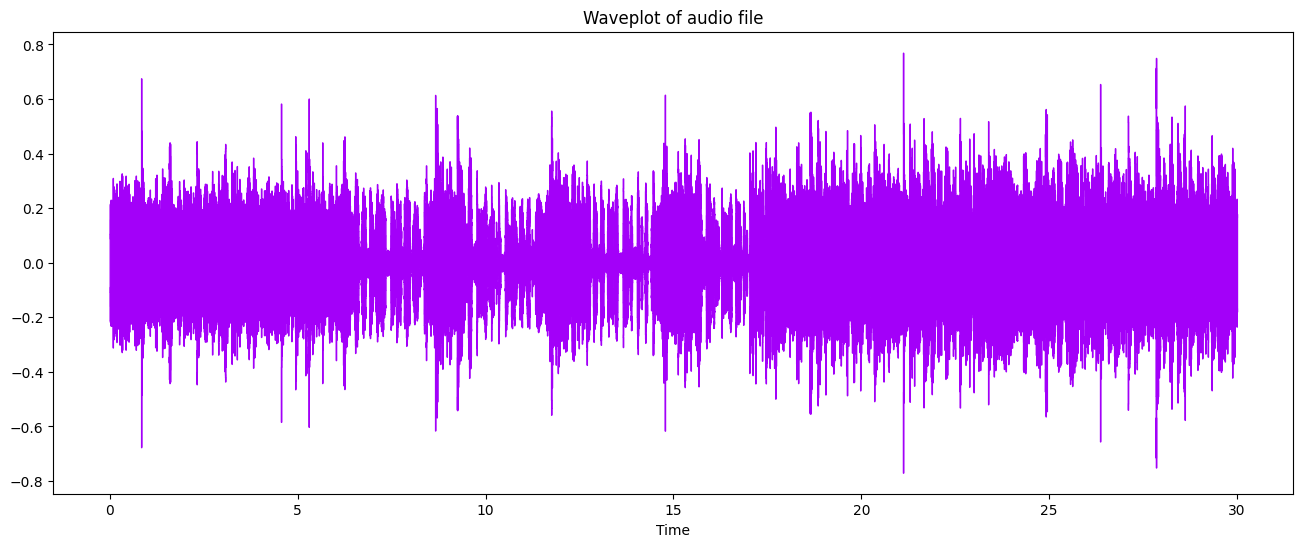

In [15]:
plt.figure(figsize=(16, 6)) 
librosa.display.waveshow(y, sr=sr, color="#A300F9") 
plt.title("Waveplot of audio file");

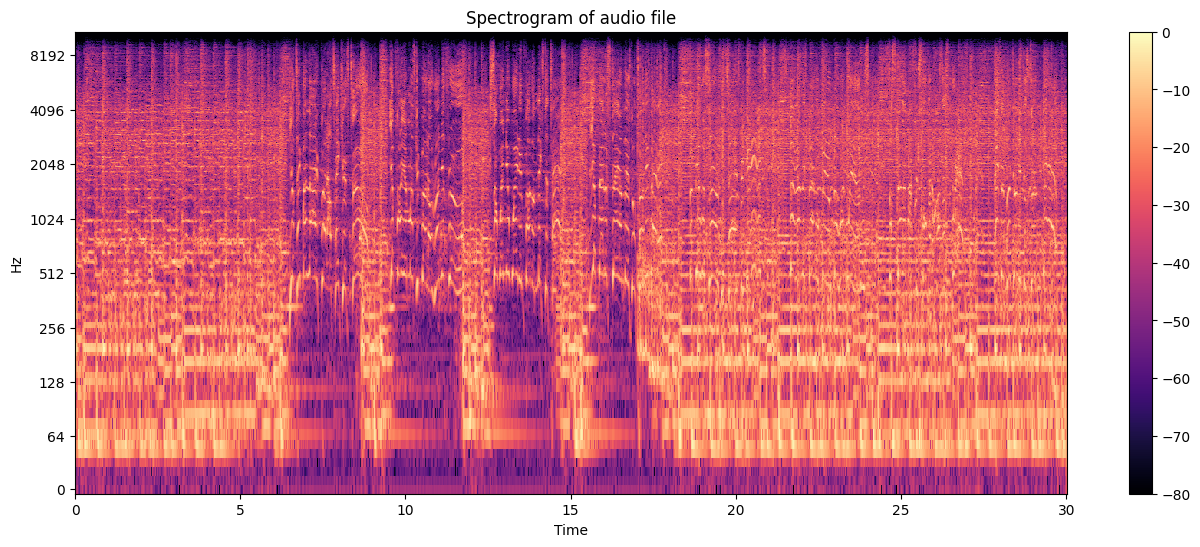

In [16]:
n_fft = 2048 
hop_length = 512  
audio_file, _ = librosa.effects.trim(y) 
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))  
DB = librosa.amplitude_to_db(D, ref = np.max)  
plt.figure(figsize = (16, 6)) 
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log') 
plt.colorbar();
plt.title("Spectrogram of audio file");
plt.show()

### Potential ways to extract features: 
`tempo, _ = librosa.beat.beat_track(y=y, sr=sr)` for tempo of a track. <br> 
`pitches, magnitudes = librosa.piptrack(y=y, sr=sr)` tracking the fundamental frequency over time. <br> 
`harmonic, percussive = librosa.effects.hpss(y)` to separate the audio into harmonic and percussive parts. <br> 
`spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)` measures the difference between the peaks and valleys in a audio. <br>